In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:

inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.

session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23',)

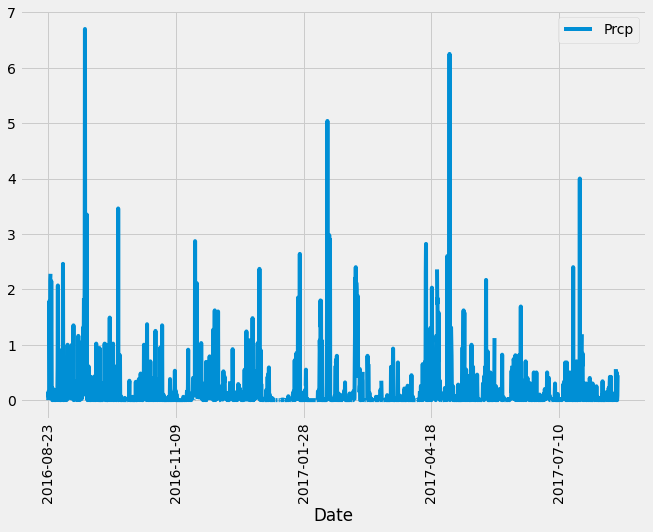

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

start_date = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores

precip = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= query_date).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precip_df = pd.DataFrame(precip)
precip_df = precip_df.rename(columns={0:"Date",1:"Prcp"})
precip_df = precip_df.set_index('Date')


# Sort the dataframe by date

precip_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data

precip_df.plot(kind="line", rot=90, figsize=(10,7))
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data

precip_df.describe()


,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.station)).all()

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.tobs)).\
group_by(measurement.station).\
order_by(desc(func.count(measurement.tobs))).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

station_data = session.query(measurement.station, func.max(measurement.tobs),func.min(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station == "USC00519281").all()

station_df = pd.DataFrame(station_data)
station_df = station_df.rename(columns={0:"Station ID",1:"High",2:"Low",3:"Average"})
station_df = station_df.set_index("Station ID")
station_df


,High,Low,Average
Station ID,,,
USC00519281,85.0,54.0,71.663781


In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps = session.query(measurement.tobs).\
    filter(measurement.station == "USC00519281").\
    filter(measurement.date >= query_date).\
    filter(measurement.date <= start_date).all()

temps_df = pd.DataFrame(temps)
temps_df

,0
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


Text(0.5, 1.0, 'TOBS for USC00519281')

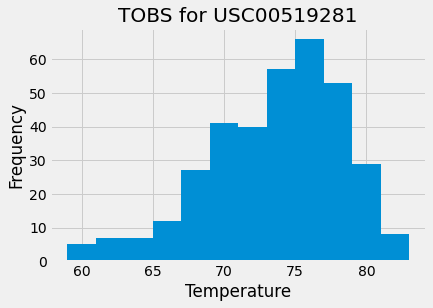

In [18]:
plt.hist(temps_df[0], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title("TOBS for USC00519281")

# Close session

In [19]:
# Close Session
session.close()